### Парсинг исходных данных

In [2]:
import numpy as np

import json

x_train = []
y_train = []

with open("data/x_train.txt", "r") as file:
    x_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))

with open("data/y_train.txt", "r") as file:
    y_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))

In [3]:
x_train, y_train

(array([[ 0.44878602, -1.31186755,  0.0852925 , ..., -0.51819492,
         -1.12322176,  0.45302913],
        [ 1.60202756,  1.29076884,  0.02501387, ...,  0.91776299,
         -0.771968  ,  0.36634343],
        [ 0.7287607 , -1.38626143, -2.02498711, ..., -0.47258403,
         -1.11627642,  0.09564287],
        ...,
        [ 0.43666857,  0.64100458, -1.87525252, ..., -0.59489407,
          1.23886575,  0.42375108],
        [ 0.84312788, -0.80936618, -1.53086641, ...,  0.22090653,
         -0.32667033, -0.65034498],
        [-0.49231737,  1.46636722, -1.52639546, ..., -1.13464199,
          0.4558241 , -0.8405369 ]]),
 array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
   

#### Загрузка в .pkl файл

In [13]:
model = Model(random_state = 42)

model.load(["data/x_train.txt", "data/y_train.txt"])
model.train_models()
model.fit()

with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pickle, json
import numpy as np

x_train = []
y_train = []

with open("data/x_train.txt", "r") as file:
    x_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))

with open("data/y_train.txt", "r") as file:
    y_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))    

In [15]:
XTrain, XTest, YTrain, YTest = train_test_split(x_train, y_train, test_size = 0.33, random_state = 42)

##### Базовый результат

In [16]:
model_init_rfc = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_init_rfc.fit(XTrain, YTrain)

roc_auc_score(YTrain, model_init_rfc.predict_proba(XTrain).T[1]), roc_auc_score(YTest, model_init_rfc.predict_proba(XTest).T[1])

(1.0, 0.9705007163586937)

##### Нахождение фичей и удаление "ненужных" колонок

In [17]:
import pandas as pd

features_rfc = pd.Series(model_init_rfc.feature_importances_)

best_features_rfc = np.array(features_rfc[features_rfc > 0.02].index)
best_features_rfc

array([ 2,  5, 15, 19, 21, 22])

In [18]:
XTrain_best_rfc = XTrain[:, best_features_rfc]
XTest_best_rfc = XTest[:, best_features_rfc]

model_best_rfc = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_best_rfc.fit(XTrain_best_rfc, YTrain)

roc_auc_score(YTrain, model_best_rfc.predict_proba(XTrain_best_rfc).T[1]), roc_auc_score(YTest, model_best_rfc.predict_proba(XTest_best_rfc).T[1])

(1.0, 0.9790970206825612)

#### Grid search

In [19]:
import matplotlib.pyplot as plt

##### Параметр n_estimators

i: 10; score: (0.9998171993151662, 0.9703905073289005)
i: 20; score: (0.9998840776144957, 0.9753682818412255)
i: 50; score: (0.9999910828934228, 0.9783806619889056)
i: 75; score: (1.0, 0.9774622534072958)
i: 100; score: (1.0, 0.9790970206825612)
i: 150; score: (1.0, 0.9799052202343779)
i: 200; score: (1.0, 0.9796664340031594)
max of n_estimators_result: 0.9799052202343779; i: 150


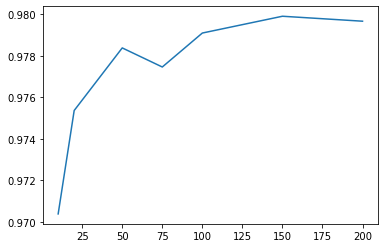

In [20]:
n_estimators_range = [10, 20, 50, 75, 100, 150, 200]
n_estimators_result = []

for n_estimators_param in n_estimators_range:
    model_best_rfc = RandomForestClassifier(n_estimators = n_estimators_param, max_depth = 10, random_state = 42)
    model_best_rfc.fit(XTrain_best_rfc, YTrain)

    score = roc_auc_score(YTrain, model_best_rfc.predict_proba(XTrain_best_rfc).T[1]), roc_auc_score(YTest, model_best_rfc.predict_proba(XTest_best_rfc).T[1])
    
    n_estimators_result.append(score[1])
    
    print("i: {0}; score: {1}".format(n_estimators_param, score))

print("max of n_estimators_result: {0}; i: {1}".format(max(n_estimators_result), n_estimators_range[n_estimators_result.index(max(n_estimators_result))]))
    
plt.plot(n_estimators_range, n_estimators_result)

##### Параметр max_depth

i: 5; score: (0.9913147381937509, 0.9775908306087212)
i: 7; score: (0.9984930089884434, 0.9788031299364461)
i: 9; score: (0.9999643315736909, 0.9803460563535507)
i: 11; score: (1.0, 0.9781786121009515)
i: 13; score: (1.0, 0.9776275669519855)
i: 15; score: (1.0, 0.9784541346754343)
max of max_depth_result: 0.9803460563535507; i: 9


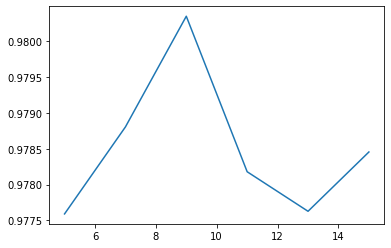

In [21]:
max_depth_range = np.arange(5, 17, 2)
max_depth_result = []

for max_depth_param in max_depth_range:
    model_best_rfc = RandomForestClassifier(n_estimators = 100, max_depth = max_depth_param, random_state = 42)
    model_best_rfc.fit(XTrain_best_rfc, YTrain)

    score = roc_auc_score(YTrain, model_best_rfc.predict_proba(XTrain_best_rfc).T[1]), roc_auc_score(YTest, model_best_rfc.predict_proba(XTest_best_rfc).T[1])
    
    max_depth_result.append(score[1])
    
    print("i: {0}; score: {1}".format(max_depth_param, score))

print("max of max_depth_result: {0}; i: {1}".format(max(max_depth_result), max_depth_range[max_depth_result.index(max(max_depth_result))]))
    
plt.plot(max_depth_range, max_depth_result)

##### Gridsearch двух параметров

In [22]:
import pandas as pd

common_result = []

for n_estimators_param in n_estimators_range:
    print("----n_estimators_param: {0}----".format(n_estimators_param))
    for max_depth_param in max_depth_range:
        model_best_rfc = RandomForestClassifier(n_estimators = n_estimators_param, max_depth = max_depth_param, random_state = 42)
        model_best_rfc.fit(XTrain_best_rfc, YTrain)

        score = roc_auc_score(YTrain, model_best_rfc.predict_proba(XTrain_best_rfc).T[1]), roc_auc_score(YTest, model_best_rfc.predict_proba(XTest_best_rfc).T[1])

        common_result.append([score[1], (n_estimators_param, max_depth_param)])

        print("max_depth_param: {0}; score: {1}".format(max_depth_param, score))

----n_estimators_param: 10----
max_depth_param: 5; score: (0.9874759238122415, 0.9681495903897726)
max_depth_param: 7; score: (0.9975210443715223, 0.9713823885970391)
max_depth_param: 9; score: (0.9992732558139535, 0.9738988281106498)
max_depth_param: 11; score: (0.999892994721073, 0.9699496712097277)
max_depth_param: 13; score: (0.9998840776144957, 0.9731273649020976)
max_depth_param: 15; score: (0.9998885361677843, 0.9738804599390176)
----n_estimators_param: 20----
max_depth_param: 5; score: (0.9897943715223285, 0.9770765218030195)
max_depth_param: 7; score: (0.998064987872735, 0.9768377355718012)
max_depth_param: 9; score: (0.9996522328434869, 0.9771683626611807)
max_depth_param: 11; score: (1.0, 0.9725212152382352)
max_depth_param: 13; score: (1.0, 0.9759376951618235)
max_depth_param: 15; score: (1.0, 0.976341794937732)
----n_estimators_param: 50----
max_depth_param: 5; score: (0.9908064631188472, 0.9792072297123544)
max_depth_param: 7; score: (0.9984840918818662, 0.979501120458469

##### Результат

Max score: 0.9803460563535507; Params: n_estimators: 100, max_depth: 9


<ipython-input-23-2724742e8150>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_result_np = np.array(common_result)


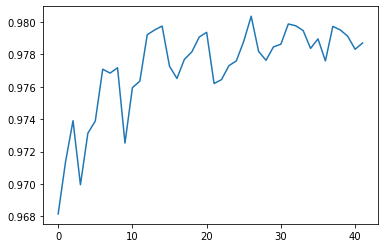

In [23]:
max_score = max(list(map(lambda x: x[0], common_result)))

common_result_np = np.array(common_result)

common_result_pd = pd.Series(list(common_result_np.T[1 :][0].T), index = common_result_np.T[0])

print("Max score: {0}; Params: n_estimators: {1}, max_depth: {2}".format(max_score, common_result_pd[max_score][0], common_result_pd[max_score][1]))

plt.plot(range(0, len(n_estimators_range) * len(max_depth_range)), list(map(lambda x: x[0], common_result)))

Оптимальные параметры: n_estimators = 100, max_depth = 9 <br />
score(на тестовой выборке) ~= 0.98

### XGBClassifier

In [24]:
from xgboost import XGBClassifier

model_init_xgb = XGBClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_init_xgb.fit(XTrain, YTrain)

roc_auc_score(YTrain, model_init_xgb.predict_proba(XTrain).T[1]), roc_auc_score(YTest, model_init_xgb.predict_proba(XTest).T[1])

(1.0, 0.9675985452408067)

In [25]:
features_xgb = pd.Series(model_init_xgb.feature_importances_)

best_features_xgb = np.array(features_xgb[features_xgb > 0.02].index)
best_features_xgb

array([ 0,  2,  5,  7, 11, 15, 16, 19, 21, 22, 25, 26])

In [26]:
XTrain_best_xgb = XTrain[:, best_features_xgb]
XTest_best_xgb = XTest[:, best_features_xgb]

model_best_xgb = XGBClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_best_xgb.fit(XTrain_best_xgb, YTrain)

roc_auc_score(YTrain, model_best_xgb.predict_proba(XTrain_best_xgb).T[1]), roc_auc_score(YTest, model_best_xgb.predict_proba(XTest_best_xgb).T[1])

(1.0, 0.9683700084493589)

i: 200; score: (1.0, 0.9696925168068771)
i: 500; score: (1.0, 0.9699496712097279)
i: 1000; score: (1.0, 0.9702435619558429)
i: 1200; score: (1.0, 0.9702068256125785)
max of n_estimators_result: 0.9702435619558429; i: 1000


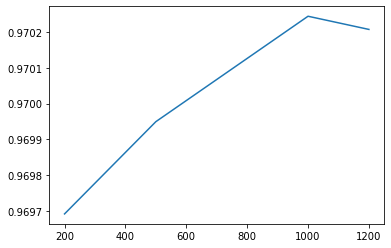

In [27]:
n_estimators_range = [200, 500, 1000, 1200]
n_estimators_result = []

for n_estimators_param in n_estimators_range:
    model_best_xgb = XGBClassifier(n_estimators = n_estimators_param, max_depth = 10, random_state = 42)
    model_best_xgb.fit(XTrain_best_xgb, YTrain)

    score = roc_auc_score(YTrain, model_best_xgb.predict_proba(XTrain_best_xgb).T[1]), roc_auc_score(YTest, model_best_xgb.predict_proba(XTest_best_xgb).T[1])
    
    n_estimators_result.append(score[1])
    
    print("i: {0}; score: {1}".format(n_estimators_param, score))

print("max of n_estimators_result: {0}; i: {1}".format(max(n_estimators_result), n_estimators_range[n_estimators_result.index(max(n_estimators_result))]))
    
plt.plot(n_estimators_range, n_estimators_result)

i: 5; score: (1.0, 0.9699129348664633)
i: 7; score: (1.0, 0.970537452701958)
i: 9; score: (1.0, 0.9703905073289005)
i: 11; score: (1.0, 0.9702435619558429)
i: 13; score: (1.0, 0.9702435619558429)
i: 15; score: (1.0, 0.9702435619558429)
i: 17; score: (1.0, 0.9702435619558429)
i: 19; score: (1.0, 0.9702435619558429)
i: 21; score: (1.0, 0.9702435619558429)
i: 23; score: (1.0, 0.9702435619558429)
max of max_depth_result: 0.970537452701958; i: 7


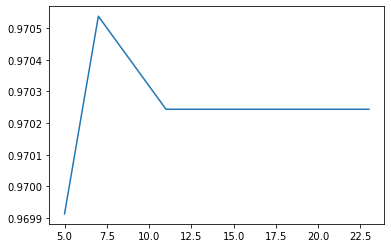

In [115]:
max_depth_range = np.arange(5, 25, 2)
max_depth_result = []

for max_depth_param in max_depth_range:
    model_best_xgb = XGBClassifier(n_estimators = 1000, max_depth = max_depth_param, random_state = 42)
    model_best_xgb.fit(XTrain_best_xgb, YTrain)

    score = roc_auc_score(YTrain, model_best_xgb.predict_proba(XTrain_best_xgb).T[1]), roc_auc_score(YTest, model_best_xgb.predict_proba(XTest_best_xgb).T[1])
    
    max_depth_result.append(score[1])
    
    print("i: {0}; score: {1}".format(max_depth_param, score))

print("max of max_depth_result: {0}; i: {1}".format(max(max_depth_result), max_depth_range[max_depth_result.index(max(max_depth_result))]))
    
plt.plot(max_depth_range, max_depth_result)

In [116]:
import pandas as pd

common_result = []

for n_estimators_param in n_estimators_range:
    print("----n_estimators_param: {0}----".format(n_estimators_param))
    for max_depth_param in max_depth_range:
        model_best_xgb = XGBClassifier(n_estimators = n_estimators_param, max_depth = max_depth_param, random_state = 42)
        model_best_xgb.fit(XTrain_best_xgb, YTrain)

        score = roc_auc_score(YTrain, model_best_xgb.predict_proba(XTrain_best_xgb).T[1]), roc_auc_score(YTest, model_best_xgb.predict_proba(XTest_best_xgb).T[1])

        common_result.append([score[1], (n_estimators_param, max_depth_param)])

        print("max_depth_param: {0}; score: {1}".format(max_depth_param, score))

----n_estimators_param: 50----
max_depth_param: 5; score: (1.0, 0.9689577899415894)
max_depth_param: 7; score: (1.0, 0.9669372910620476)
max_depth_param: 9; score: (1.0, 0.9675985452408068)
max_depth_param: 11; score: (1.0, 0.9672311818081629)
max_depth_param: 13; score: (1.0, 0.9672311818081629)
max_depth_param: 15; score: (1.0, 0.9672311818081629)
max_depth_param: 17; score: (1.0, 0.9672311818081629)
max_depth_param: 19; score: (1.0, 0.9672311818081629)
max_depth_param: 21; score: (1.0, 0.9672311818081629)
max_depth_param: 23; score: (1.0, 0.9672311818081629)
----n_estimators_param: 60----
max_depth_param: 5; score: (1.0, 0.9685904265089453)
max_depth_param: 7; score: (1.0, 0.9668638183755189)
max_depth_param: 9; score: (1.0, 0.9669005547187833)
max_depth_param: 11; score: (1.0, 0.9677822269571287)
max_depth_param: 13; score: (1.0, 0.9677822269571287)
max_depth_param: 15; score: (1.0, 0.9677822269571287)
max_depth_param: 17; score: (1.0, 0.9677822269571287)
max_depth_param: 19; score

Max score: 0.9698027258366702; Params: n_estimators: 80, max_depth: 5


<ipython-input-118-2724742e8150>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_result_np = np.array(common_result)


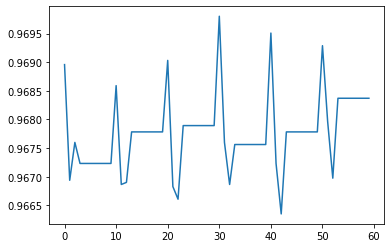

In [118]:
max_score = max(list(map(lambda x: x[0], common_result)))

common_result_np = np.array(common_result)

common_result_pd = pd.Series(list(common_result_np.T[1 :][0].T), index = common_result_np.T[0])

print("Max score: {0}; Params: n_estimators: {1}, max_depth: {2}".format(max_score, common_result_pd[max_score][0], common_result_pd[max_score][1]))

plt.plot(range(0, len(n_estimators_range) * len(max_depth_range)), list(map(lambda x: x[0], common_result)))

### Gradient Boosting Classifier

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

model_init_gbc = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_init_gbc.fit(XTrain, YTrain)

roc_auc_score(YTrain, model_init_gbc.predict_proba(XTrain).T[1]), roc_auc_score(YTest, model_init_gbc.predict_proba(XTest).T[1])

(1.0, 0.9155431468351641)

In [34]:
features_gbc = pd.Series(model_init_gbc.feature_importances_)

best_features_gbc = np.array(features_gbc[features_gbc > 0.02].index)
best_features_gbc

array([ 2,  5,  7, 15, 19, 21, 26])

In [36]:
XTrain_best_gbc = XTrain[:, best_features_gbc]
XTest_best_gbc = XTest[:, best_features_gbc]

model_best_gbc = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
model_best_gbc.fit(XTrain_best_gbc, YTrain)

roc_auc_score(YTrain, model_best_gbc.predict_proba(XTrain_best_gbc).T[1]), roc_auc_score(YTest, model_best_gbc.predict_proba(XTest_best_gbc).T[1])

(1.0, 0.9326439146247383)

i: 500; score: (1.0, 0.9404871239116858)
i: 1000; score: (1.0, 0.9403769148818926)
i: 1500; score: (1.0, 0.9404503875684214)
i: 2000; score: (1.0, 0.9404503875684214)
max of n_estimators_result: 0.9404871239116858; i: 500


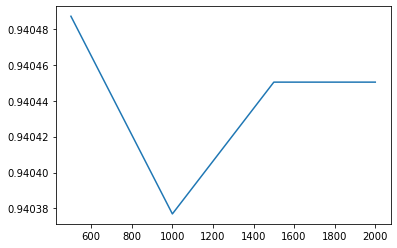

In [51]:
n_estimators_range = [500, 1000, 1500, 2000]
n_estimators_result = []

for n_estimators_param in n_estimators_range:
    model_best_gbc = GradientBoostingClassifier(n_estimators = n_estimators_param, max_depth = 10, random_state = 42)
    model_best_gbc.fit(XTrain_best_gbc, YTrain)

    score = roc_auc_score(YTrain, model_best_gbc.predict_proba(XTrain_best_gbc).T[1]), roc_auc_score(YTest, model_best_gbc.predict_proba(XTest_best_gbc).T[1])
    
    n_estimators_result.append(score[1])
    
    print("i: {0}; score: {1}".format(n_estimators_param, score))

print("max of n_estimators_result: {0}; i: {1}".format(max(n_estimators_result), n_estimators_range[n_estimators_result.index(max(n_estimators_result))]))
    
plt.plot(n_estimators_range, n_estimators_result)

i: 1; score: (0.9818403124554145, 0.975974431505088)
i: 3; score: (1.0, 0.9813746739649535)
i: 5; score: (1.0, 0.9796113294882628)
i: 7; score: (1.0, 0.9767826310569045)
i: 9; score: (1.0, 0.9685169538224165)
i: 11; score: (1.0, 0.9246904963079974)
i: 13; score: (1.0, 0.913008339149921)
i: 15; score: (1.0, 0.9090775504206312)
i: 17; score: (1.0, 0.9129348664633922)
i: 19; score: (1.0, 0.9128981301201278)
i: 21; score: (1.0, 0.9129348664633922)
i: 23; score: (1.0, 0.91291649829176)
max of max_depth_result: 0.9813746739649535; i: 3


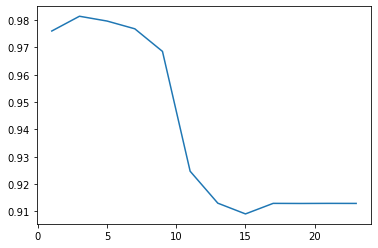

In [55]:
max_depth_range = np.arange(1, 25, 2)
max_depth_result = []

for max_depth_param in max_depth_range:
    model_best_gbc = GradientBoostingClassifier(n_estimators = 500, max_depth = max_depth_param, random_state = 42)
    model_best_gbc.fit(XTrain_best_gbc, YTrain)

    score = roc_auc_score(YTrain, model_best_gbc.predict_proba(XTrain_best_gbc).T[1]), roc_auc_score(YTest, model_best_gbc.predict_proba(XTest_best_gbc).T[1])
    
    max_depth_result.append(score[1])
    
    print("i: {0}; score: {1}".format(max_depth_param, score))

print("max of max_depth_result: {0}; i: {1}".format(max(max_depth_result), max_depth_range[max_depth_result.index(max(max_depth_result))]))
    
plt.plot(max_depth_range, max_depth_result)

In [57]:
import pandas as pd

common_result = []

for n_estimators_param in n_estimators_range:
    print("----n_estimators_param: {0}----".format(n_estimators_param))
    for max_depth_param in max_depth_range:
        model_best_gbc = GradientBoostingClassifier(n_estimators = n_estimators_param, max_depth = max_depth_param, random_state = 42)
        model_best_gbc.fit(XTrain_best_gbc, YTrain)

        score = roc_auc_score(YTrain, model_best_gbc.predict_proba(XTrain_best_gbc).T[1]), roc_auc_score(YTest, model_best_gbc.predict_proba(XTest_best_gbc).T[1])

        common_result.append([score[1], (n_estimators_param, max_depth_param)])

        print("max_depth_param: {0}; score: {1}".format(max_depth_param, score))

----n_estimators_param: 500----
max_depth_param: 1; score: (0.9818403124554145, 0.975974431505088)
max_depth_param: 3; score: (1.0, 0.9813746739649535)
max_depth_param: 5; score: (1.0, 0.9796113294882628)
max_depth_param: 7; score: (1.0, 0.9767826310569045)
max_depth_param: 9; score: (1.0, 0.9685169538224165)
max_depth_param: 11; score: (1.0, 0.9246904963079974)
max_depth_param: 13; score: (1.0, 0.913008339149921)
max_depth_param: 15; score: (1.0, 0.9090775504206312)
max_depth_param: 17; score: (1.0, 0.9129348664633922)
max_depth_param: 19; score: (1.0, 0.9128981301201278)
max_depth_param: 21; score: (1.0, 0.9129348664633922)
max_depth_param: 23; score: (1.0, 0.91291649829176)
----n_estimators_param: 1000----
max_depth_param: 1; score: (0.9901198459123984, 0.9774989897505602)
max_depth_param: 3; score: (1.0, 0.9828808640387936)
max_depth_param: 5; score: (1.0, 0.9799786929209067)
max_depth_param: 7; score: (1.0, 0.9770030491164908)
max_depth_param: 9; score: (1.0, 0.9691782080011756)
m

Max score: 0.9828808640387936; Params: n_estimators: 1000, max_depth: 3


<ipython-input-59-2724742e8150>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_result_np = np.array(common_result)


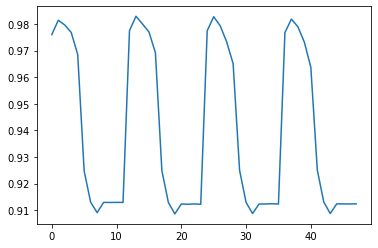

In [59]:
max_score = max(list(map(lambda x: x[0], common_result)))

common_result_np = np.array(common_result)

common_result_pd = pd.Series(list(common_result_np.T[1 :][0].T), index = common_result_np.T[0])

print("Max score: {0}; Params: n_estimators: {1}, max_depth: {2}".format(max_score, common_result_pd[max_score][0], common_result_pd[max_score][1]))

plt.plot(range(0, len(n_estimators_range) * len(max_depth_range)), list(map(lambda x: x[0], common_result)))

### Cat Boosting Classifier

In [61]:
from catboost import CatBoostClassifier

model_init_cbc = CatBoostClassifier(silent = True, random_state = 42)
model_init_cbc.fit(XTrain, YTrain)

roc_auc_score(YTrain, model_init_cbc.predict_proba(XTrain).T[1]), roc_auc_score(YTest, model_init_cbc.predict_proba(XTest).T[1])

(1.0, 0.9792072297123544)

In [63]:
features_cbc = pd.Series(model_init_cbc.feature_importances_)

best_features_cbc = np.array(features_cbc[features_cbc > 0.02].index)
best_features_cbc

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [64]:
XTrain_best_cbc = XTrain[:, best_features_cbc]
XTest_best_cbc = XTest[:, best_features_cbc]

model_best_cbc = CatBoostClassifier(silent = True, random_state = 42)
model_best_cbc.fit(XTrain_best_cbc, YTrain)

roc_auc_score(YTrain, model_best_cbc.predict_proba(XTrain_best_cbc).T[1]), roc_auc_score(YTest, model_best_cbc.predict_proba(XTest_best_cbc).T[1])

(1.0, 0.9792072297123544)

i: 50; score: (1.0, 0.9744315050879836)
i: 60; score: (1.0, 0.9756805407589728)
i: 70; score: (1.0, 0.9806766834429301)
i: 80; score: (1.0, 0.9804562653833437)
i: 90; score: (1.0, 0.9767826310569045)
i: 100; score: (1.0, 0.9767458947136402)
max of n_estimators_result: 0.9806766834429301; i: 70


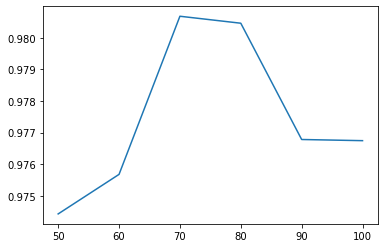

In [83]:
n_estimators_range = [50, 60, 70, 80, 90, 100]
n_estimators_result = []

for n_estimators_param in n_estimators_range:
    model_best_cbc = CatBoostClassifier(n_estimators = n_estimators_param, max_depth = 10, random_state = 42, silent = True)
    model_best_cbc.fit(XTrain_best_cbc, YTrain)

    score = roc_auc_score(YTrain, model_best_cbc.predict_proba(XTrain_best_cbc).T[1]), roc_auc_score(YTest, model_best_cbc.predict_proba(XTest_best_cbc).T[1])
    
    n_estimators_result.append(score[1])
    
    print("i: {0}; score: {1}".format(n_estimators_param, score))

print("max of n_estimators_result: {0}; i: {1}".format(max(n_estimators_result), n_estimators_range[n_estimators_result.index(max(n_estimators_result))]))
    
plt.plot(n_estimators_range, n_estimators_result)

i: 1; score: (0.925243437009559, 0.9434627677161016)
i: 3; score: (0.9914752461121416, 0.9782153484442158)
i: 5; score: (0.9993847196461692, 0.9795011204584696)
i: 7; score: (1.0, 0.9730722603872011)
i: 9; score: (1.0, 0.9760111678483524)
max of max_depth_result: 0.9795011204584696; i: 5


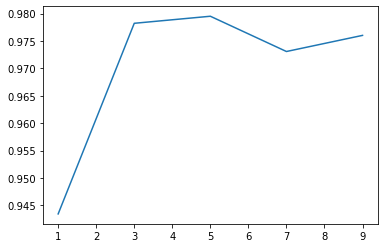

In [84]:
max_depth_range = np.arange(1, 11, 2)
max_depth_result = []

for max_depth_param in max_depth_range:
    model_best_cbc = CatBoostClassifier(n_estimators = 70, max_depth = max_depth_param, random_state = 42, silent = True)
    model_best_cbc.fit(XTrain_best_cbc, YTrain)

    score = roc_auc_score(YTrain, model_best_cbc.predict_proba(XTrain_best_cbc).T[1]), roc_auc_score(YTest, model_best_cbc.predict_proba(XTest_best_cbc).T[1])
    
    max_depth_result.append(score[1])
    
    print("i: {0}; score: {1}".format(max_depth_param, score))

print("max of max_depth_result: {0}; i: {1}".format(max(max_depth_result), max_depth_range[max_depth_result.index(max(max_depth_result))]))
    
plt.plot(max_depth_range, max_depth_result)

In [86]:
import pandas as pd

common_result = []

for n_estimators_param in n_estimators_range:
    print("----n_estimators_param: {0}----".format(n_estimators_param))
    for max_depth_param in max_depth_range:
        model_best_cbc = CatBoostClassifier(n_estimators = n_estimators_param, max_depth = max_depth_param, random_state = 42, silent = True)
        model_best_cbc.fit(XTrain_best_cbc, YTrain)

        score = roc_auc_score(YTrain, model_best_cbc.predict_proba(XTrain_best_cbc).T[1]), roc_auc_score(YTest, model_best_cbc.predict_proba(XTest_best_cbc).T[1])

        common_result.append([score[1], (n_estimators_param, max_depth_param)])

        print("max_depth_param: {0}; score: {1}".format(max_depth_param, score))

----n_estimators_param: 50----
max_depth_param: 1; score: (0.9231612926237696, 0.9422137320451122)
max_depth_param: 3; score: (0.9925542160079897, 0.9787663935931817)
max_depth_param: 5; score: (0.9991172064488515, 0.9788398662797105)
max_depth_param: 7; score: (1.0, 0.9758274861320304)
max_depth_param: 9; score: (1.0, 0.9750192865802138)
----n_estimators_param: 60----
max_depth_param: 1; score: (0.9245345270366673, 0.9474119246170236)
max_depth_param: 3; score: (0.9909848052503925, 0.9741743506851329)
max_depth_param: 5; score: (0.9991172064488515, 0.9806032107564014)
max_depth_param: 7; score: (1.0, 0.9756070680724442)
max_depth_param: 9; score: (1.0, 0.973806987252489)
----n_estimators_param: 70----
max_depth_param: 1; score: (0.925243437009559, 0.9434627677161016)
max_depth_param: 3; score: (0.9914752461121416, 0.9782153484442158)
max_depth_param: 5; score: (0.9993847196461692, 0.9795011204584696)
max_depth_param: 7; score: (1.0, 0.9730722603872011)
max_depth_param: 9; score: (1.0,

Max score: 0.9806032107564014; Params: n_estimators: 60, max_depth: 5


<ipython-input-87-2724742e8150>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_result_np = np.array(common_result)


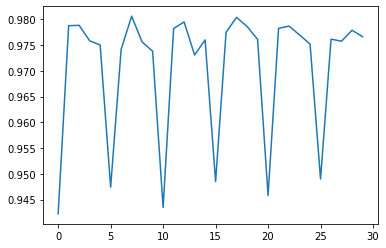

In [87]:
max_score = max(list(map(lambda x: x[0], common_result)))

common_result_np = np.array(common_result)

common_result_pd = pd.Series(list(common_result_np.T[1 :][0].T), index = common_result_np.T[0])

print("Max score: {0}; Params: n_estimators: {1}, max_depth: {2}".format(max_score, common_result_pd[max_score][0], common_result_pd[max_score][1]))

plt.plot(range(0, len(n_estimators_range) * len(max_depth_range)), list(map(lambda x: x[0], common_result)))

### Light GBM Classifier

In [95]:
from lightgbm import LGBMClassifier

model_init_lgbm = LGBMClassifier(random_state = 42)
model_init_lgbm.fit(XTrain, YTrain)

roc_auc_score(YTrain, model_init_lgbm.predict_proba(XTrain).T[1]), roc_auc_score(YTest, model_init_lgbm.predict_proba(XTest).T[1])

(1.0, 0.969398626060762)

In [96]:
features_lgbm = pd.Series(model_init_lgbm.feature_importances_)

best_features_lgbm = np.array(features_lgbm[features_lgbm > 0.02].index)
best_features_lgbm

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [97]:
XTrain_best_lgbm = XTrain[:, best_features_lgbm]
XTest_best_lgbm = XTest[:, best_features_lgbm]

model_best_lgbm = LGBMClassifier(random_state = 42)
model_best_lgbm.fit(XTrain_best_lgbm, YTrain)

roc_auc_score(YTrain, model_best_lgbm.predict_proba(XTrain_best_lgbm).T[1]), roc_auc_score(YTest, model_best_lgbm.predict_proba(XTest_best_lgbm).T[1])

(1.0, 0.969398626060762)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 50; score: (1.0, 0.9707578707615444)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 60; score: (1.0, 0.9706476617317511)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 70; score: (1.0, 0.972594687924764)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 80; score: (1.0, 0.970537452701958)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 90; score: (1.0, 0.9710884978509239)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 100; score: (1.0, 0

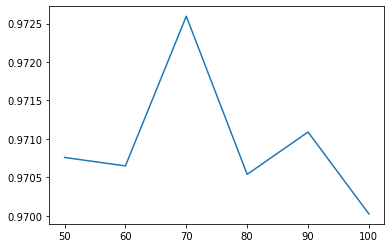

In [103]:
n_estimators_range = [50, 60, 70, 80, 90, 100]
n_estimators_result = []

for n_estimators_param in n_estimators_range:
    model_best_lgbm = LGBMClassifier(n_estimators = n_estimators_param, max_depth = 10, random_state = 42)
    model_best_lgbm.fit(XTrain_best_lgbm, YTrain)

    score = roc_auc_score(YTrain, model_best_lgbm.predict_proba(XTrain_best_lgbm).T[1]), roc_auc_score(YTest, model_best_lgbm.predict_proba(XTest_best_lgbm).T[1])
    
    n_estimators_result.append(score[1])
    
    print("i: {0}; score: {1}".format(n_estimators_param, score))

print("max of n_estimators_result: {0}; i: {1}".format(max(n_estimators_result), n_estimators_range[n_estimators_result.index(max(n_estimators_result))]))
    
plt.plot(n_estimators_range, n_estimators_result)

i: 3; score: (0.9985197603081752, 0.9670842364351053)
i: 4; score: (0.9999643315736909, 0.9705007163586936)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 5; score: (1.0, 0.9694353624040263)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 6; score: (1.0, 0.9688108445685316)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 7; score: (1.0, 0.967157709121634)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 8; score: (1.0, 0.9681128540465082)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
i: 9; score: (1.0, 0.9706476617317513)
[LightGBM] [Warning] Accuracy may be bad since y

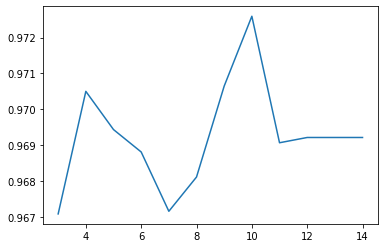

In [109]:
max_depth_range = np.arange(3, 15, 1)
max_depth_result = []

for max_depth_param in max_depth_range:
    model_best_lgbm = LGBMClassifier(n_estimators = 70, max_depth = max_depth_param, random_state = 42, silent = True)
    model_best_lgbm.fit(XTrain_best_lgbm, YTrain)

    score = roc_auc_score(YTrain, model_best_lgbm.predict_proba(XTrain_best_lgbm).T[1]), roc_auc_score(YTest, model_best_lgbm.predict_proba(XTest_best_lgbm).T[1])
    
    max_depth_result.append(score[1])
    
    print("i: {0}; score: {1}".format(max_depth_param, score))

print("max of max_depth_result: {0}; i: {1}".format(max(max_depth_result), max_depth_range[max_depth_result.index(max(max_depth_result))]))
    
plt.plot(max_depth_range, max_depth_result)

In [110]:
import pandas as pd

common_result = []

for n_estimators_param in n_estimators_range:
    print("----n_estimators_param: {0}----".format(n_estimators_param))
    for max_depth_param in max_depth_range:
        model_best_lgbm = LGBMClassifier(n_estimators = n_estimators_param, max_depth = max_depth_param, random_state = 42, silent = True)
        model_best_lgbm.fit(XTrain_best_lgbm, YTrain)

        score = roc_auc_score(YTrain, model_best_lgbm.predict_proba(XTrain_best_lgbm).T[1]), roc_auc_score(YTest, model_best_lgbm.predict_proba(XTest_best_lgbm).T[1])

        common_result.append([score[1], (n_estimators_param, max_depth_param)])

        print("max_depth_param: {0}; score: {1}".format(max_depth_param, score))

----n_estimators_param: 50----
max_depth_param: 3; score: (0.9963083178770152, 0.9678189633003931)
max_depth_param: 4; score: (0.9992955485803967, 0.9714558612835679)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 5; score: (0.9999197460408047, 0.9698027258366702)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 6; score: (1.0, 0.9666434003159325)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 7; score: (1.0, 0.9660188824804379)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 8; score: (1.0, 0.9701333529260497)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR

max_depth_param: 5; score: (1.0, 0.9721905881488556)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 6; score: (1.0, 0.9701333529260497)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 7; score: (1.0, 0.9697292531501414)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 8; score: (1.0, 0.9676352815840711)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 9; score: (1.0, 0.9702802982991072)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
max_depth_param: 10; score: (1.0, 0.9710884978509239)
[LightGBM] [Warning] Accuracy m

Max score: 0.972594687924764; Params: n_estimators: 70, max_depth: 10


<ipython-input-114-2724742e8150>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_result_np = np.array(common_result)


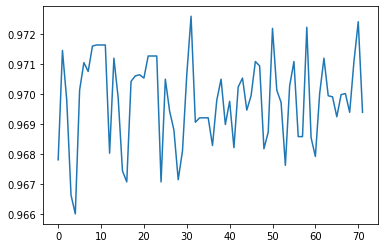

In [114]:
max_score = max(list(map(lambda x: x[0], common_result)))

common_result_np = np.array(common_result)

common_result_pd = pd.Series(list(common_result_np.T[1 :][0].T), index = common_result_np.T[0])

print("Max score: {0}; Params: n_estimators: {1}, max_depth: {2}".format(max_score, common_result_pd[max_score][0], common_result_pd[max_score][1]))

plt.plot(range(0, len(n_estimators_range) * len(max_depth_range)), list(map(lambda x: x[0], common_result)))

### Композиционная модель

In [182]:
import numpy as np

import json, pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

class Model:
    def __init__(self, random_state):
        self.random_state = random_state
        self.hyperparams = [(100, 9), # RFC
                            (1000, 3), # GBR
                            (80, 5), # XGB
                            (60, 5), # CBC
                            (70, 10)] # LGBM
        self.models_features = [
            [2,  5, 15, 19, 21, 22],
            [2,  5,  7, 15, 19, 21, 26],
            [0,  2,  5,  7, 11, 15, 16, 19, 21, 22, 25, 26],
            [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
            [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]

    def load(self, path_arr):
        x_train = []
        y_train = []

        with open(path_arr[0], "r") as file:
            x_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))

        with open(path_arr[1], "r") as file:
            y_train = np.array(json.loads(''.join(list(map(lambda x: x.strip(), file.readlines())))))

        self.XTrain, self.XComposition, self.YTrain, self.YComposition = train_test_split(x_train, y_train, test_size = 0.5, random_state = 42)

    def save(self):
        return {"models_vector": self.models_vector, "composition_model": self.composition_model, "models_features": self.models_features}

    def train_models(self):
        self.model_RFC = RandomForestClassifier(n_estimators = self.hyperparams[0][0], max_depth = self.hyperparams[0][1], random_state = 42)
        self.model_RFC.fit(self.XTrain[:, self.models_features[0]], self.YTrain)

        print("RFR trained")
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.model_RFC.predict_proba(self.XTrain[:, self.models_features[0]]).T[1]), roc_auc_score(self.YComposition, self.model_RFC.predict_proba(self.XComposition[:, self.models_features[0]]).T[1]))))

        self.model_GBC = GradientBoostingClassifier(n_estimators = self.hyperparams[1][0], max_depth = self.hyperparams[1][1], random_state = 42)
        self.model_GBC.fit(self.XTrain[:, self.models_features[1]], self.YTrain)

        print("GBC trained")
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.model_GBC.predict_proba(self.XTrain[:, self.models_features[1]]).T[1]), roc_auc_score(self.YComposition, self.model_GBC.predict_proba(self.XComposition[:, self.models_features[1]]).T[1]))))

        self.model_XGB = XGBClassifier(n_estimators = self.hyperparams[2][0], max_depth = self.hyperparams[2][1], random_state = 42)
        self.model_XGB.fit(self.XTrain[:, self.models_features[2]], self.YTrain)

        print("XGB trained")
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.model_XGB.predict_proba(self.XTrain[:, self.models_features[2]]).T[1]), roc_auc_score(self.YComposition, self.model_XGB.predict_proba(self.XComposition[:, self.models_features[2]]).T[1]))))

        self.model_CBC = CatBoostClassifier(n_estimators = self.hyperparams[3][0], max_depth = self.hyperparams[3][1], random_state = 42, silent = True)
        self.model_CBC.fit(self.XTrain[:, self.models_features[3]], self.YTrain)

        print("CBC trained")
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.model_CBC.predict_proba(self.XTrain[:, self.models_features[3]]).T[1]), roc_auc_score(self.YComposition, self.model_CBC.predict_proba(self.XComposition[:, self.models_features[3]]).T[1]))))

        self.model_LGBM = LGBMClassifier(n_estimators = self.hyperparams[4][0], max_depth = self.hyperparams[4][1], random_state = 42)
        self.model_LGBM.fit(self.XTrain[:, self.models_features[4]], self.YTrain)

        print("LGBM trained")
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.model_LGBM.predict_proba(self.XTrain[:, self.models_features[4]]).T[1]), roc_auc_score(self.YComposition, self.model_LGBM.predict_proba(self.XComposition[:, self.models_features[4]]).T[1]))))

        self.models_vector = np.array([self.model_RFC, self.model_GBC, self.model_XGB, self.model_CBC, self.model_LGBM], dtype = object)

    def composition_predict(self, X):
        return np.array([self.models_vector[modelIndex].predict(X[:, self.models_features[modelIndex]]) for modelIndex in range(len(self.models_vector))])

    def composition_predict_proba(self, X):
        return np.array([self.models_vector[modelIndex].predict_proba(X[:, self.models_features[modelIndex]]).T[1] for modelIndex in range(len(self.models_vector))])

    def composition_models(self):
        self.composition_arr = self.composition_predict_proba(self.XComposition).T

        self.composition_model = LogisticRegression().fit(self.composition_arr, self.YComposition)

    def fit(self):
        self.train_models()
        print("training completed")
        self.composition_models()
        
        print("Score: {0} ".format((roc_auc_score(self.YTrain, self.predict_proba(self.XTrain)), roc_auc_score(self.YComposition, self.predict_proba(self.XComposition)))))

    def predict(self, X):
        enter_composition = self.composition_predict(X).T

        return self.composition_model.predict(enter_composition)

    def predict_proba(self, X):
        enter_composition = self.composition_predict_proba(X).T

        return self.composition_model.predict_proba(enter_composition).T[1]

In [183]:
model_comp = Model(random_state = 42)

model_comp.load(["data/x_train.txt", "data/y_train.txt"])
print("---datasets loaded---")

model_comp.fit()
print("---models fitted---")

data = model_comp.save()

with open("model.pkl", "wb") as file:
    pickle.dump(data, file)

---datasets loaded---
RFR trained
Score: (1.0, 0.9667088546756596) 
GBC trained
Score: (1.0, 0.9593553245005527) 
XGB trained
Score: (1.0, 0.9614860859674138) 
CBC trained
Score: (0.9995813204508857, 0.9606209647703423) 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LGBM trained
Score: (1.0, 0.9536999951937711) 
training completed
Score: (1.0, 0.966100065685128) 
---models fitted---
